In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import loguniform
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
import csv
import random
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import warnings
%matplotlib inline
import os



# **Loading the Dataset**

In [ ]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = 'a7e473a25f91d534f833232b746c044a'
os.environ["KAGGLE_USERNAME"] = 'jaiswaladityaranjit'

!kaggle datasets download -d jessicali9530/lfw-dataset


!unzip "lfw-dataset.zip"

Streaming output truncated to the last 5000 lines.
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0022.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0023.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0024.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0025.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0026.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0027.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0028.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0029.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Si

# Function to implement **LBP**

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
import cv2

# Load pre-trained ResNet-50 model
resnet = models.resnet50(pretrained=True)
# Remove the last fully connected layer
resnet = nn.Sequential(*list(resnet.children())[:-1])
# Set the model to evaluation mode
resnet.eval()




def get_pixel(img, center, x, y):
    new_value = 0
    try:
        if img[x][y] >= center:
            new_value = 1
    except:
        pass
    return new_value

def lbp_calculated_pixel(img, x, y):
    center = img[x][y]
    val_ar = []
    val_ar.append(get_pixel(img, center, x-1, y+1))     # top_right
    val_ar.append(get_pixel(img, center, x, y+1))       # right
    val_ar.append(get_pixel(img, center, x+1, y+1))     # bottom_right
    val_ar.append(get_pixel(img, center, x+1, y))       # bottom
    val_ar.append(get_pixel(img, center, x+1, y-1))     # bottom_left
    val_ar.append(get_pixel(img, center, x, y-1))       # left
    val_ar.append(get_pixel(img, center, x-1, y-1))     # top_left
    val_ar.append(get_pixel(img, center, x-1, y))       # top

    power_val = [1, 2, 4, 8, 16, 32, 64, 128]
    val = 0
    for i in range(len(val_ar)):
        val += val_ar[i] * power_val[i]
    return val


def calcLBP(img):
    height, width, channel = img.shape
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    img_lbp = np.zeros((height, width,3), np.uint8)
    for i in range(0, height):
        for j in range(0, width):
             img_lbp[i, j] = lbp_calculated_pixel(img_gray, i, j)
    hist_lbp = cv2.calcHist([img_lbp], [0], None, [256], [0, 256])
    return(hist_lbp)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 61.5MB/s]


# **Implementing LBP on images of people whose number of faces present in dataset are atleast 70.**

In [ ]:
lfw_folder = '/content/lfw-deepfunneled/lfw-deepfunneled'
X, y = [], []
for folder_name in os.listdir(lfw_folder):
    folder_path = os.path.join(lfw_folder, folder_name)
    if os.path.isdir(folder_path):
        num_images = len(os.listdir(folder_path))
        if num_images > 70:
            for image_name in os.listdir(folder_path):
                image_path = os.path.join(folder_path, image_name)
                image = imread(image_path)
                # hog_feature = compute_hog(image)
                lbp_feature = calcLBP(image)
                # lbp_feature = extract_features(image_path, resnet).numpy()
                # hog_feature = hog_feature.reshape(-1)
                # lbp_feature = lbp_feature.reshape(-1)
                lbp_feature = lbp_feature.flatten()
                # combined_feature = np.concatenate((cnn_feature))

                X.append(lbp_feature)
                y.append(folder_name)

In [ ]:
X_array = np.array(X)
Y_array = np.array(y)

In [ ]:
print(X_array.shape)
print(Y_array.shape)

(1288, 256)
(1288,)


In [ ]:
X_array[0].shape

(256,)

# *Plotting Grayscale images*

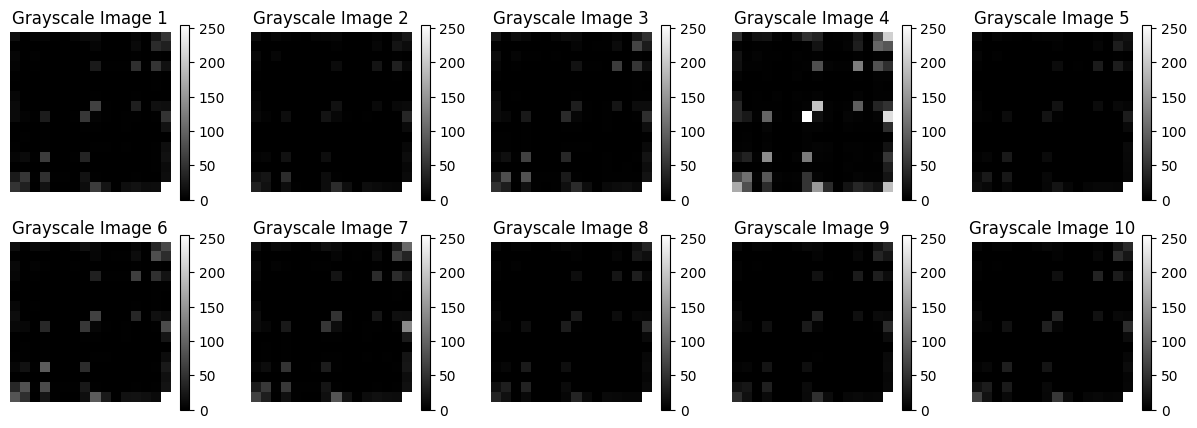

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Example array containing histograms of LBP features for each image
 # Assuming 10 samples

# Define a function to normalize the histogram values to [0, 255]
def normalize_histogram(hist):
    hist_min = np.min(hist)
    hist_max = np.max(hist)
    return ((hist - hist_min) / (hist_max - hist_min)) * 255

# Plot grayscale images corresponding to LBP histograms
plt.figure(figsize=(15, 5))
for i in range(10):
    hist = X_array[i]
    normalized_hist = normalize_histogram(hist)
    grayscale_image = normalized_hist.reshape(16, 16)
    plt.subplot(2, 5, i+1)
    plt.imshow(grayscale_image, cmap='gray')
    plt.colorbar()
    plt.title(f"Grayscale Image {i+1}")
    plt.axis('off')
plt.show()


# **Splitting the dataset in Training and Testing data**

In [ ]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X_array,Y_array,test_size=0.3,random_state=42)


# **Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=71,max_depth=21,min_samples_split=2,min_samples_leaf=5)
rf_classifier.fit(X_train,y_train)
y_pred_rf = rf_classifier.predict(X_test)


from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,y_pred_rf))

0.4186046511627907


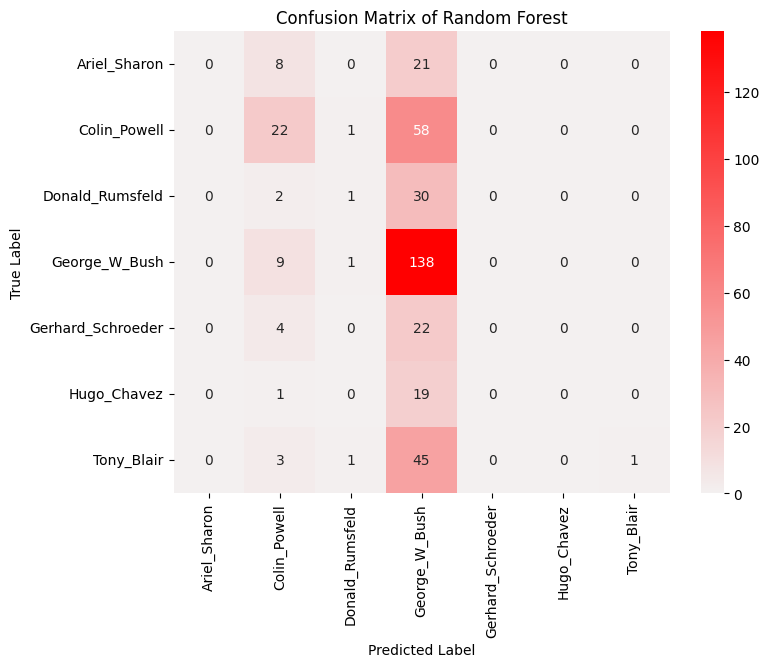

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Calculate confusion matrix
#y_pred = rf_classifier.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred_rf)
# Get the actual feature names
# Assuming you have a variable feature_names containing the feature names
# Replace feature_names with your actual feature names
feature_names = np.unique(y_test)

# Define a custom color palette
custom_palette = sns.light_palette("#FF0000", as_cmap=True)

# Plot confusion matrix heatmap with custom color palette
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=custom_palette, xticklabels=feature_names, yticklabels=feature_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of Random Forest')
plt.show()


# **KNN (K-Nearest Neighbours )**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier()
from sklearn.model_selection import GridSearchCV
k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range ,)
grid = GridSearchCV(neigh, param_grid, cv=10, scoring='accuracy', return_train_score=False)
grid.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30]},
             scoring='accuracy')

In [ ]:
y_pred=grid.predict(X_test)

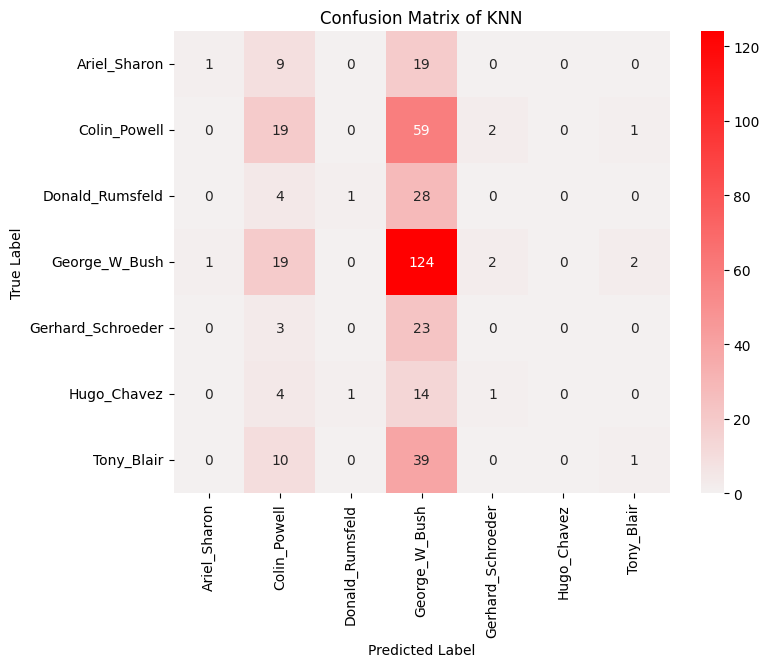

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
# Get the actual feature names
# Assuming you have a variable feature_names containing the feature names
# Replace feature_names with your actual feature names
feature_names = np.unique(y_test)

# Define a custom color palette
custom_palette = sns.light_palette("#FF0000", as_cmap=True)

# Plot confusion matrix heatmap with custom color palette
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=custom_palette, xticklabels=feature_names, yticklabels=feature_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of KNN')
plt.show()


In [ ]:
nn=grid.best_params_

In [ ]:
from sklearn.metrics import accuracy_score
print("accuracy score whith knn with n_neighbors=",nn['n_neighbors'],"(best case) is:",accuracy_score(y_test, y_pred))

accuracy score whith knn with n_neighbors= 22 (best case) is: 0.3772609819121447


# **Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
# Define logistic regression classifier
logistic_regression = LogisticRegression(max_iter=200)

# Define the parameter grid for grid search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'penalty': ['l1', 'l2'],  # Penalty term
}

# Create GridSearchCV object
grid_logistic_regression = GridSearchCV(logistic_regression, param_grid, cv=10, scoring='accuracy', return_train_score=False)

# Fit the model to the training data
grid_logistic_regression.fit(X_train, y_train)



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

GridSearchCV(cv=10, estimator=LogisticRegression(max_iter=200),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2']},
             scoring='accuracy')

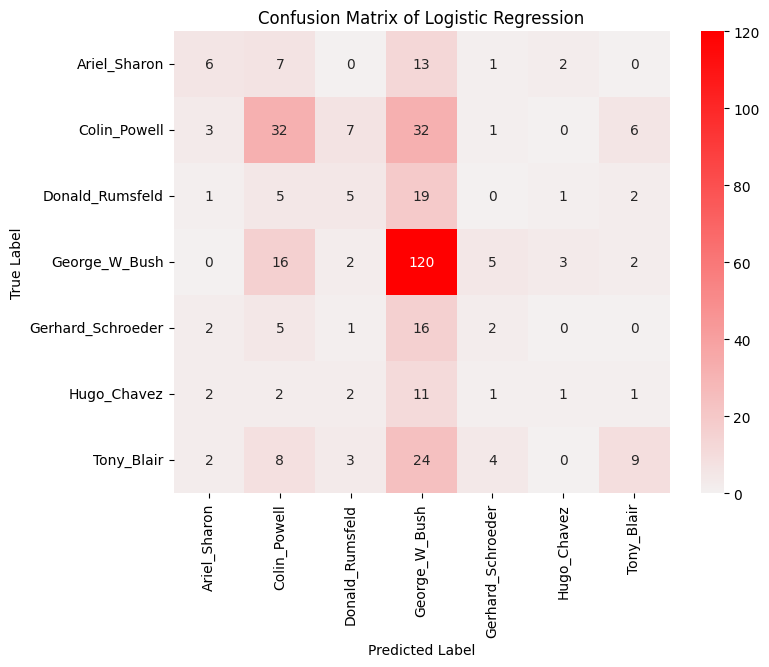

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Calculate confusion matrix
y_pred = grid_logistic_regression.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
# Get the actual feature names
# Assuming you have a variable feature_names containing the feature names
# Replace feature_names with your actual feature names
feature_names = np.unique(y_test)

# Define a custom color palette
custom_palette = sns.light_palette("#FF0000", as_cmap=True)

# Plot confusion matrix heatmap with custom color palette
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=custom_palette, xticklabels=feature_names, yticklabels=feature_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of Logistic Regression')
plt.show()


In [ ]:
# Print the best parameters and best score
print("Best parameters found: ", grid_logistic_regression.best_params_)
from sklearn.metrics import accuracy_score
print("Accuracy using best parameter",accuracy_score(y_test,y_pred))


Best parameters found:  {'C': 100, 'penalty': 'l2'}
Accuracy using best parameter 0.45219638242894056


# **Gaussian Naive Bayes**

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB(var_smoothing=0.01)
gnb.fit(X_train,y_train)
y_pred_nvb = gnb.predict(X_test)
print(accuracy_score(y_test,y_pred_nvb))

0.35658914728682173


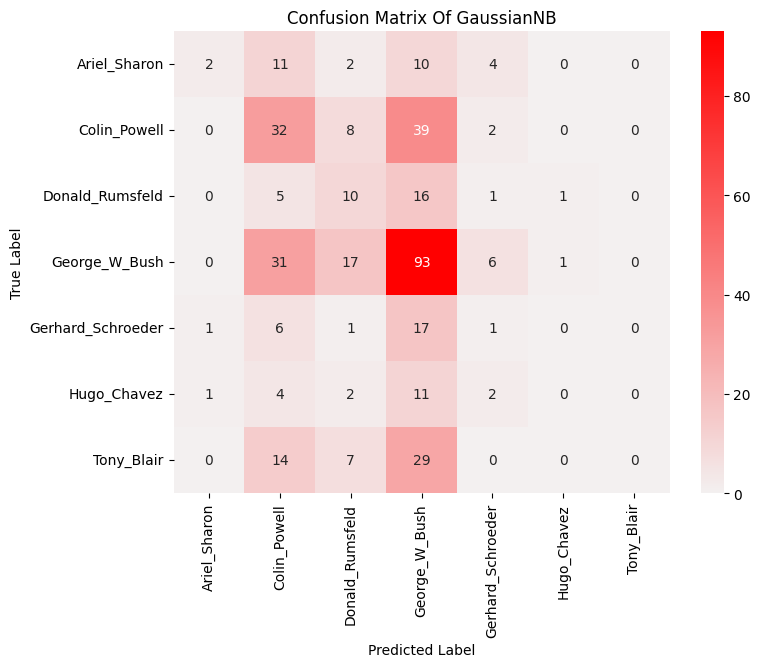

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Calculate confusion matrix
#y_pred = gnb.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred_nvb)
# Get the actual feature names
# Assuming you have a variable feature_names containing the feature names
# Replace feature_names with your actual feature names
feature_names = np.unique(y_test)

# Define a custom color palette
custom_palette = sns.light_palette("#FF0000", as_cmap=True)

# Plot confusion matrix heatmap with custom color palette
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=custom_palette, xticklabels=feature_names, yticklabels=feature_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Of GaussianNB')
plt.show()


In [ ]:
param_grid = {
    'var_smoothing': [1e-12, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
}
grid_search = GridSearchCV(estimator=gnb, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print('best score',grid_search.best_score_)

Best parameters: {'var_smoothing': 0.01}
best score 0.4017863720073665


# **Linear SVM**

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Linear SVM
svm_linear = SVC(kernel='linear',C=1)
svm_linear.fit(X_train, y_train)
y_pred_linear = svm_linear.predict(X_test)
print("Linear SVM Classification Report:")
print(classification_report(y_test, y_pred_linear))
print(accuracy_score(y_test,y_pred_linear))


Linear SVM Classification Report:
                   precision    recall  f1-score   support

     Ariel_Sharon       0.33      0.31      0.32        29
     Colin_Powell       0.45      0.47      0.46        81
  Donald_Rumsfeld       0.19      0.24      0.21        33
    George_W_Bush       0.57      0.59      0.58       148
Gerhard_Schroeder       0.26      0.31      0.28        26
      Hugo_Chavez       0.14      0.10      0.12        20
       Tony_Blair       0.44      0.32      0.37        50

         accuracy                           0.43       387
        macro avg       0.34      0.33      0.33       387
     weighted avg       0.44      0.43      0.43       387

0.43410852713178294


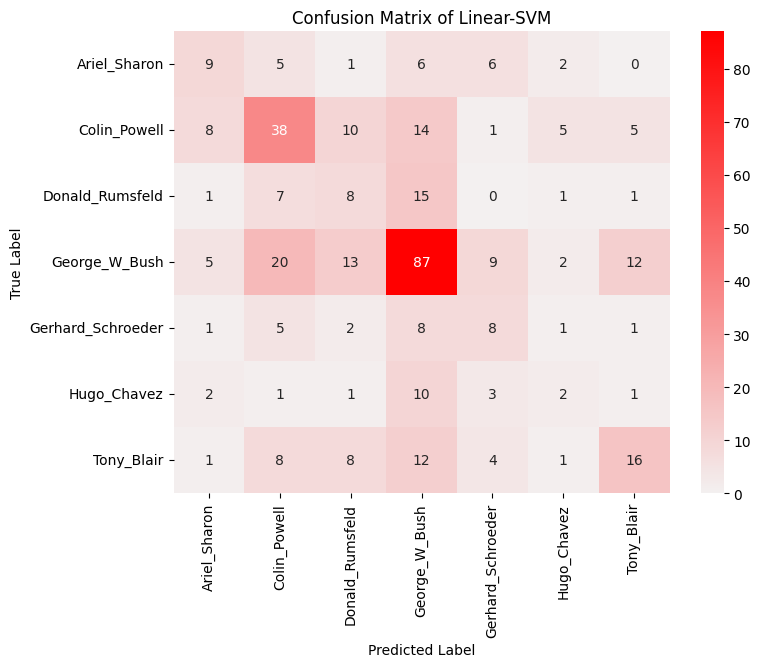

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_linear)
# Get the actual feature names
# Assuming you have a variable feature_names containing the feature names
# Replace feature_names with your actual feature names
feature_names = np.unique(y_test)

# Define a custom color palette
custom_palette = sns.light_palette("#FF0000", as_cmap=True)

# Plot confusion matrix heatmap with custom color palette
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=custom_palette, xticklabels=feature_names, yticklabels=feature_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of Linear-SVM')
plt.show()


# **Polynomial SVM**

In [ ]:
# Polynomial SVM
svm_poly = SVC(kernel='poly', degree=2,C=1)  # You can adjust the degree parameter as needed
svm_poly.fit(X_train, y_train)
y_pred_poly = svm_poly.predict(X_test)
print("\nPolynomial SVM Classification Report:")
print(classification_report(y_test, y_pred_poly))
print(accuracy_score(y_test,y_pred_poly))



Polynomial SVM Classification Report:
                   precision    recall  f1-score   support

     Ariel_Sharon       0.00      0.00      0.00        29
     Colin_Powell       0.45      0.12      0.19        81
  Donald_Rumsfeld       0.00      0.00      0.00        33
    George_W_Bush       0.39      0.96      0.55       148
Gerhard_Schroeder       0.00      0.00      0.00        26
      Hugo_Chavez       0.00      0.00      0.00        20
       Tony_Blair       0.00      0.00      0.00        50

         accuracy                           0.39       387
        macro avg       0.12      0.15      0.11       387
     weighted avg       0.24      0.39      0.25       387

0.39276485788113696


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


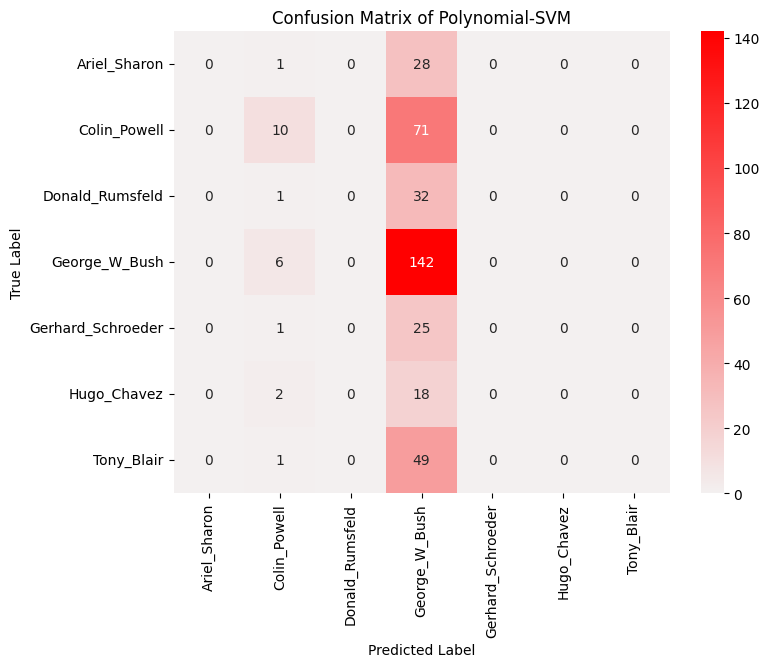

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Calculate confusion matrix
#y_pred = gnb.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred_poly)
# Get the actual feature names
# Assuming you have a variable feature_names containing the feature names
# Replace feature_names with your actual feature names
feature_names = np.unique(y_test)

# Define a custom color palette
custom_palette = sns.light_palette("#FF0000", as_cmap=True)

# Plot confusion matrix heatmap with custom color palette
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=custom_palette, xticklabels=feature_names, yticklabels=feature_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of Polynomial-SVM')
plt.show()


# **RBF - SVM**

In [ ]:
# RBF SVM
svm_rbf = SVC(kernel='rbf',C=100,gamma=0.001)
svm_rbf.fit(X_train, y_train)
y_pred_rbf = svm_rbf.predict(X_test)
print("\nRBF SVM Classification Report:")
print(classification_report(y_test, y_pred_rbf))
print(accuracy_score(y_test,y_pred_rbf))


RBF SVM Classification Report:
                   precision    recall  f1-score   support

     Ariel_Sharon       0.00      0.00      0.00        29
     Colin_Powell       0.00      0.00      0.00        81
  Donald_Rumsfeld       0.00      0.00      0.00        33
    George_W_Bush       0.38      1.00      0.55       148
Gerhard_Schroeder       0.00      0.00      0.00        26
      Hugo_Chavez       0.00      0.00      0.00        20
       Tony_Blair       0.00      0.00      0.00        50

         accuracy                           0.38       387
        macro avg       0.05      0.14      0.08       387
     weighted avg       0.15      0.38      0.21       387

0.38242894056847543


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


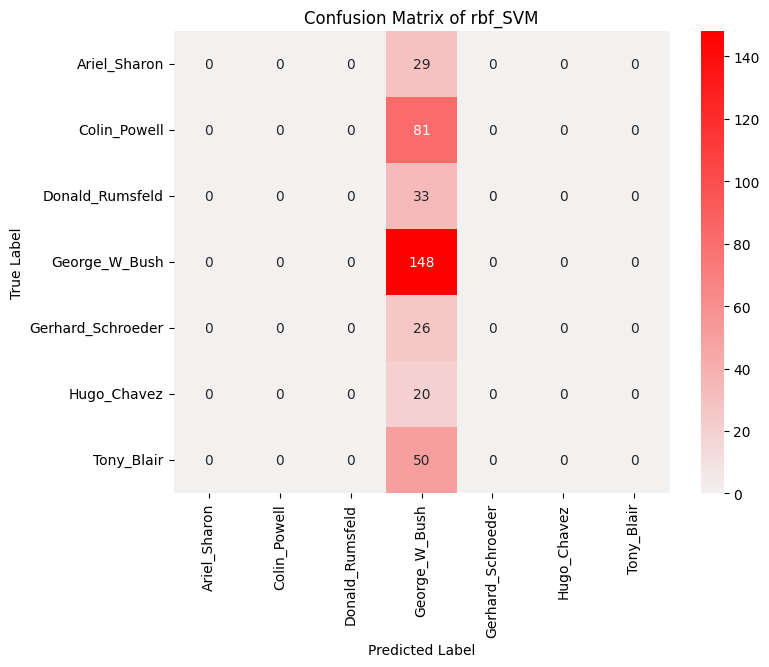

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_rbf)
# Get the actual feature names
# Assuming you have a variable feature_names containing the feature names
# Replace feature_names with your actual feature names
feature_names = np.unique(y_test)

# Define a custom color palette
custom_palette = sns.light_palette("#FF0000", as_cmap=True)

# Plot confusion matrix heatmap with custom color palette
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=custom_palette, xticklabels=feature_names, yticklabels=feature_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of rbf_SVM')
plt.show()


In [31]:


# Define parameter grids for each SVM kernel type
param_grid_linear = {
    'C': [0.01, 0.1, 1, 10, 100]  # Regularization parameter C
}

param_grid_poly = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization parameter C
    'degree': [2, 3, 4],  # Polynomial degree
}

param_grid_rbf = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization parameter C
    'gamma': [0.001, 0.01, 0.1, 1, 10]  # RBF kernel width
}

# Perform grid search for each SVM kernel type
grid_search_linear = GridSearchCV(estimator=SVC(kernel='linear'), param_grid=param_grid_linear, cv=5, scoring='accuracy')
grid_search_linear.fit(X_train, y_train)
print("Best parameters for Linear SVM:", grid_search_linear.best_params_)

grid_search_poly = GridSearchCV(estimator=SVC(kernel='poly'), param_grid=param_grid_poly, cv=5, scoring='accuracy')
grid_search_poly.fit(X_train, y_train)
print("Best parameters for Polynomial SVM:", grid_search_poly.best_params_)

grid_search_rbf = GridSearchCV(estimator=SVC(kernel='rbf'), param_grid=param_grid_rbf, cv=5, scoring='accuracy')
grid_search_rbf.fit(X_train, y_train)
print("Best parameters for RBF SVM:", grid_search_rbf.best_params_)


Best parameters for Linear SVM: {'C': 0.01}
Best parameters for Polynomial SVM: {'C': 100, 'degree': 3}
Best parameters for RBF SVM: {'C': 0.01, 'gamma': 0.001}


In [32]:
print("Accuracy for the best parameters for linear svm", accuracy_score(y_test,grid_search_linear.predict(X_test)))
print("Accuracy for the best parameters for polynomial svm", accuracy_score(y_test,grid_search_poly.predict(X_test)))
print("Accuracy for the best parameters for rbf svm", accuracy_score(y_test,grid_search_rbf.predict(X_test)))

Accuracy for the best parameters for linear svm 0.43410852713178294
Accuracy for the best parameters for polynomial svm 0.4005167958656331
Accuracy for the best parameters for rbf svm 0.38242894056847543


# **Applying Label Encoder**

In [33]:
from sklearn.preprocessing import LabelEncoder

# Convert class labels to integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [34]:
print(np.unique(y_train_encoded))

[0 1 2 3 4 5 6]


# **MLP (via Sci-Kit Learn)**

In [35]:
from sklearn.neural_network import MLPClassifier

In [36]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
mlp_classifier.fit(X_train, y_train_encoded)

# Predict on the test set
y_pred_mlp = mlp_classifier.predict(X_test)

# Convert predictions back to original labels


# Calculate accuracy
accuracy = accuracy_score(y_test_encoded, y_pred_mlp)
print("Accuracy:", accuracy)

Accuracy: 0.23772609819121446


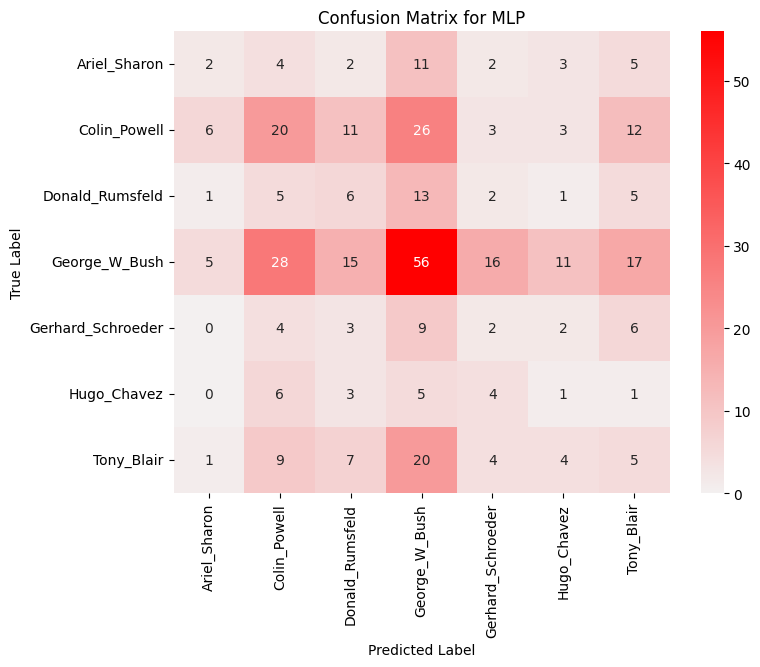

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Calculate confusion matrix

conf_matrix = confusion_matrix(y_test_encoded, y_pred_mlp)
# Get the actual feature names
# Assuming you have a variable feature_names containing the feature names
# Replace feature_names with your actual feature names
feature_names = np.unique(y_test)

# Define a custom color palette
custom_palette = sns.light_palette("#FF0000", as_cmap=True)

# Plot confusion matrix heatmap with custom color palette
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=custom_palette, xticklabels=feature_names, yticklabels=feature_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for MLP')
plt.show()


# **MLP (via Tensor Flow - Keras)**

In [38]:
from keras.models import Sequential
from keras.layers import Dense

In [39]:
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(np.unique(y_train)), activation='softmax'))

In [40]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train_encoded, epochs=15, batch_size=32, verbose=1,validation_split=0.2)

# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test, y_test_encoded)
print("Test Accuracy:", accuracy)

Epoch 1/15
23/23 [==============================] - 2s 20ms/step - loss: 245.1359 - accuracy: 0.2486 - val_loss: 97.0908 - val_accuracy: 0.2431
Epoch 2/15
23/23 [==============================] - 0s 6ms/step - loss: 69.0673 - accuracy: 0.2708 - val_loss: 56.4096 - val_accuracy: 0.2597
Epoch 3/15
23/23 [==============================] - 0s 6ms/step - loss: 45.6253 - accuracy: 0.2958 - val_loss: 39.6503 - val_accuracy: 0.2099
Epoch 4/15
23/23 [==============================] - 0s 5ms/step - loss: 34.0591 - accuracy: 0.2639 - val_loss: 38.5488 - val_accuracy: 0.3260
Epoch 5/15
23/23 [==============================] - 0s 7ms/step - loss: 28.1784 - accuracy: 0.3403 - val_loss: 43.0769 - val_accuracy: 0.1602
Epoch 6/15
23/23 [==============================] - 0s 6ms/step - loss: 28.7086 - accuracy: 0.3125 - val_loss: 24.2055 - val_accuracy: 0.3094
Epoch 7/15
23/23 [==============================] - 0s 8ms/step - loss: 18.1593 - accuracy: 0.3639 - val_loss: 22.6050 - val_accuracy: 0.2486
Epoc

In [41]:
y_pred_mlpt=model.predict(X_test)

# Find the index of the maximum value along each row
l=[]
for i in range(y_pred_mlpt.shape[0]):

      max_index = np.argmax(y_pred_mlpt[i], axis=0)
      l.append(max_index)

# Reshape max_indices to have shape (387, 1)
l=np.array(l)
y_pred_mlpt = l.reshape(-1,1)

13/13 [==============================] - 0s 2ms/step


In [42]:
y_pred_mlpt.shape

(387, 1)

In [43]:
y_test_encoded.shape

(387,)

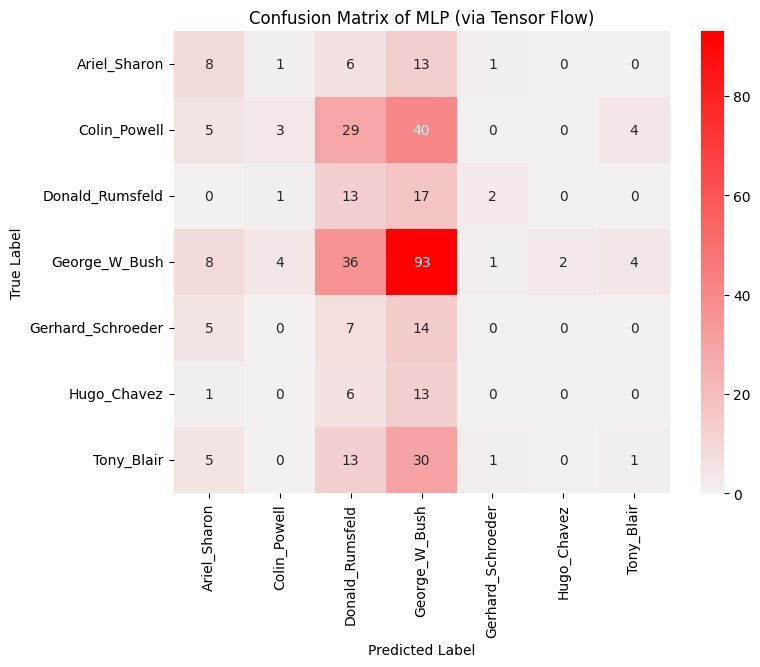

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_mlpt)
# Get the actual feature names
# Assuming you have a variable feature_names containing the feature names
# Replace feature_names with your actual feature names
feature_names = np.unique(y_test)

# Define a custom color palette
custom_palette = sns.light_palette("#FF0000", as_cmap=True)

# Plot confusion matrix heatmap with custom color palette
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=custom_palette, xticklabels=feature_names, yticklabels=feature_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of MLP (via Tensor Flow)')
plt.show()
